In [1]:
def analyse_my_stock_portfolio2(tickers, timeframe, start_date, end_date, weights, simulate, inv_amt, num_sim, num_trade_days):
   
    # Import packages required
    import sys
    import pandas as pd
    import numpy as np
    import datetime as dt
    from pathlib import Path
    import matplotlib.pyplot as plt 
    from matplotlib.gridspec import GridSpec
    import seaborn as sns
    import os
    import json
    import requests
    from dotenv import load_dotenv
    import alpaca_trade_api as tradeapi
    from MCForecastTools import MCSimulation
    %matplotlib inline
    load_dotenv()         
    
    
    ####################################################################################################################################### DATA SET UP ###########################################################################################################################

    
    #Define variables
    tickers = tickers
    tf = timeframe
    start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
    end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()
    num_sim = num_sim
    wt=weights
    num_trade_days=num_trade_days   
    simulate = simulate
    
    #Read in alpaca keys
    alpaca_key = os.getenv('ALPACA_API_KEY')
    alpaca_secret_key = os.getenv('ALPACA_API_SECRET_KEY')
    
    print(f"Your alpaca key is {type(alpaca_key)}.")
    print(f"Your alpaca secret key is {type(alpaca_secret_key)}.")
    
    #Set up Alpaca trade api
    api = tradeapi.REST(alpaca_key, alpaca_secret_key, api_version='V2')
    
    #Define parameters to get stock data from Alpaca api    
    tickers_df = api.get_barset(tickers, timeframe=tf, start=start_date, end=end_date, limit=1000).df
    tickers_df.dropna(inplace=True, axis=1, how='all')
    print()
    print()
    print(f"This is your dataframe: \n {tickers_df.head()} with {tickers_df.shape} rows (represnts no. of days) and columns")

    #Calc daily returns
    close_prices = tickers_df.loc(axis=1)[:,'close']
    print()
    print()
    print(f"These are your close prices:\n {close_prices}")  
    print()   

    ######################################################################################################################################### ANALYSES ###########################################################################################################################

    daily_returns = close_prices.pct_change().dropna()
    print()
    print()
    print(f"These are your daily returns:\n {daily_returns}")  
    print()   

    #Calc portfolio and cumulative returns
    portfolio_cum_return = (1+daily_returns).cumprod()  

    #Calc 21-day rolling std dev
    roll_std = daily_returns.rolling(window=21).std()

    #Calc correlation
    correlation = daily_returns.corr()
    print()
    print()
    print(f"This is your correlation matrix \n {correlation}")  
    print()  

    # Calculate Annualzied Sharpe Ratios
    sharpe_ratio = (daily_returns.mean()*252) / (daily_returns.std()*np.sqrt(252))
    print()
    print()
    print(f"This is your Sharpe Ratio:\n {sharpe_ratio}")  
    print()      

    #Define paramters to run Monte-Carlo Simulation
    MC = MCSimulation(portfolio_data=tickers_df, weights=wt, num_simulation=num_sim, num_trading_days=num_trade_days)
    print()
    print(f"This is your portfolio for Monte-Carlo simulation: \n {MC.portfolio_data.head()}")
    print()     


    if simulate == 'yes':
        #Run Monte-Carlo simulation to determine cumulative returns
        print("Running simulation..........................")
        print()
        print()
        print()

        #Summarise cumulative returns
        MC_summary = MC.summarize_cumulative_return()
        print()
        print(f"Here is the summary of the Monte-Carlo simulation {MC_summary}")

        #Extract confidence interval to determine range for future cumulative returns
        ci_lower = round(MC_summary[8] * inv_amt, 2)
        ci_upper = round(MC_summary[9] * inv_amt, 2)

        print()
        print(f"If you were to invest ${inv_amt} in {tickers[0:]} with a weighting of {wt}, then your invested amount could range from ${ci_lower} to ${ci_upper} after {num_trade_days} trading days or {num_trade_days/252} years.")
        print()
        print()
        print()

    elif simulate == 'no':
            pass
    else: 
            pass


    ########################################################################################################################################## PLOTS ##############################################################################################################################


    #Plot daily returns
    fig1 = plt.figure()
    plot1 = daily_returns.plot(title='Daily returns', figsize=(15, 10))   
    plot1.set_xlabel("")
    plot1.figure.savefig('DailyReturns_LinePlot.png', bbox_inches="tight") 

    #Plot daily returns_box  
    fig2 = plt.figure()
    plot2 = sns.boxplot(data=daily_returns).set_title('Daily returns')
    sns.set(rc={'figure.figsize':(15, 10)})
    plot2.figure.savefig('DailyReturns_BoxPlot.png', bbox_inches="tight")

    #Plot cumulative returns
    fig3 = plt.figure()
    plot3 = portfolio_cum_return.plot(title='Cumulative Returns', figsize=(15, 10))
    plot3.set_xlabel("")
    plot3.figure.savefig('CumulativeReturns.png', bbox_inches="tight")

    #Plot 21-day rolling std dev
    fig4 = plt.figure()
    plot4 = roll_std.plot(figsize=(15, 10), title='Rolling 21-day standard deviation')
    plot4.set_xlabel(" ")
    plot4.figure.savefig('21-day_rol_StdDev.png', bbox_inches="tight")

    #Plot correlation
    fig5 = plt.figure()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)  
    plot5 = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap=cmap, mask=mask)
    sns.set(rc={'figure.figsize':(15,10)})
    plot5.figure.savefig('Correlation.png', bbox_inches="tight")

    #Plot Sharpe Ratio
    fig6 = plt.figure()
    plot6 = sharpe_ratio.plot(kind='bar', title='Sharpe ratios', edgecolor='red', color='black', ylabel='Sharpe ratio', xlabel='Portfolios', figsize=(15, 10))
    plot6.figure.savefig('SharpeRatio.png', bbox_inches="tight")

    plt.show()

   #Save outputs to text file
    with open('Summary.txt', 'w') as sys.stdout:
        print(f"Your alpaca key is {type(alpaca_key)}.")
        print(f"Your alpaca secret key is {type(alpaca_secret_key)}.")
        print(f"This is your dataframe: \n {tickers_df.head()} with {tickers_df.shape} rows (represnts no. of days) and columns")
        print(f"These are your close prices:\n {close_prices}")  
        print(f"This is your correlation matrix \n {correlation}")  
        print(f"This is your Sharpe Ratio:\n {sharpe_ratio}")  
        print(f"This is your portfolio for Monte-Carlo simulation: \n {MC.portfolio_data.head()}")
        print(f"Here is the summary of the Monte-Carlo simulation {MC_summary}")
        print(f"If you were to invest ${inv_amt} in {tickers[0:]} with a weighting of {wt}, then your invested amount could range from ${ci_lower} to ${ci_upper} after {num_trade_days} trading days or {num_trade_days/252} years.")



In [2]:
tickers = []

new = 'yes'

while new == 'yes':
    new_ticker = input('Please type in the ticker for the stock to be analyzed:')
    tickers.append(new_ticker)
    new = input('Would you like to input another ticker value (yes/no)')
print()
print(f"These are the tickers you're interested in{tickers}")

Please type in the ticker for the stock to be analyzed: AAPL
Would you like to input another ticker value (yes/no) yes
Please type in the ticker for the stock to be analyzed: GOOG
Would you like to input another ticker value (yes/no) no



These are the tickers you're interested in['AAPL', 'GOOG']


In [3]:
timeframe = input("Please type in the timeframe (1D, 5Y, 10M):")
while timeframe != "1D" and timeframe != "1Y":
    timeframe = input("Error. Please type in a valid timeframe:")
    
print()  
print(f"This will be the resolution of your data {timeframe}")   

Please type in the timeframe (1D, 5Y, 10M): 1D



This will be the resolution of your data 1D


In [4]:
start_date_list = []
end_date_list = []

typed = 'no'

if typed == 'no':
    strt_dt = input("Please type in your start date (YYYY-MM-DD)")
    start_date_list.append(strt_dt)
    
    end_dt = input("Please type in your end date (YYYY-MM-DD)")
    end_date_list.append(end_dt)
    
    typed = input("Have you entered both dates (yes/no)?")
    print()
else:
    pass


start_date = start_date_list[0]
end_date = end_date_list[0]


Please type in your start date (YYYY-MM-DD) 2019-01-01
Please type in your end date (YYYY-MM-DD) 2021-01-01
Have you entered both dates (yes/no)? yes


In [7]:
print()   
print(f"This is your start_date {start_date}")
print()
print(f"This is your end date {end_date}")


This is your start_date 2019-01-01

This is your end date 2021-01-01


In [ ]:
weights = [0.5, 0.5]

In [9]:
simulate = input("Would you like to simulate potential returns for you invested amount (yes/no)?")

print()
print(f"You have chosen {simulate} to stimulate potential returns.")

Would you like to simulate potential returns for you invested amount (yes/no)? yes



You have chosen yes to stimulate potential returns.


In [10]:
num_sim = int(input("How many simulations would you like to run?"))

print()
print(f"You have chosen to run {num_sim} stimulations.")

How many simulations would you like to run? 50



You have chosen to run 50 stimulations.


In [11]:
num_trade_days = int(input("Across how many trade days would you like to run simulations (252 trade days/yer)?"))

print()
print(f"You have chosen to run stimulations across {num_sim}days.")

Across how many trade days would you like to run simulations (252 trade days/yer)? 50



You have chosen to run stimulations across 50days.


In [12]:
inv_amt = int(input("What is the investment amount you want to simulate?"))

print()
print(f"You have to run stimulations using ${inv_amt}.")

What is the investment amount you want to simulate? 10000



You have to run stimulations using $10000.


Your alpaca key is <class 'str'>.
Your alpaca secret key is <class 'str'>.


This is your dataframe: 
                              AAPL                                        \
                             open      high     low     close    volume   
time                                                                      
2019-01-02 00:00:00-05:00  154.89  158.8500  154.23  157.5225  27803621   
2019-01-03 00:00:00-05:00  143.98  145.7200  142.00  142.2900  82418448   
2019-01-04 00:00:00-05:00  144.53  148.5499  143.80  148.1200  51267225   
2019-01-07 00:00:00-05:00  148.70  148.8300  145.90  147.9100  49982480   
2019-01-08 00:00:00-05:00  149.56  151.8200  148.52  150.6300  36592406   

                              GOOG                                          
                              open       high        low    close   volume  
time                                                                        
2019-01-02 00:00:00-05:00  1016.57  1052.3200  1015.7100  1044.61

<Figure size 432x288 with 0 Axes>

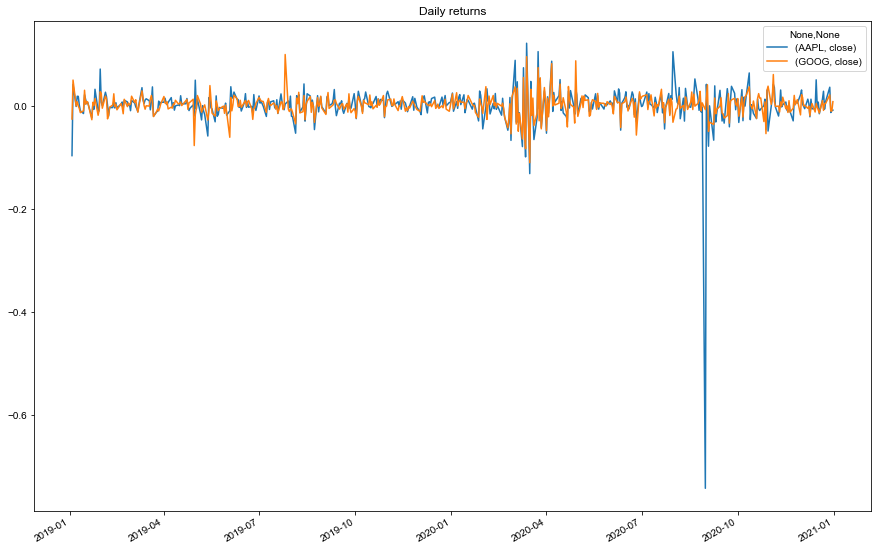

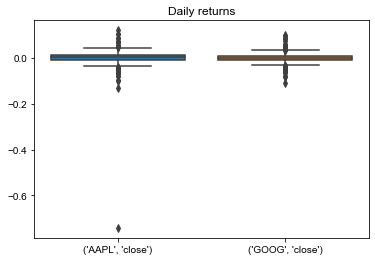

<Figure size 1080x720 with 0 Axes>

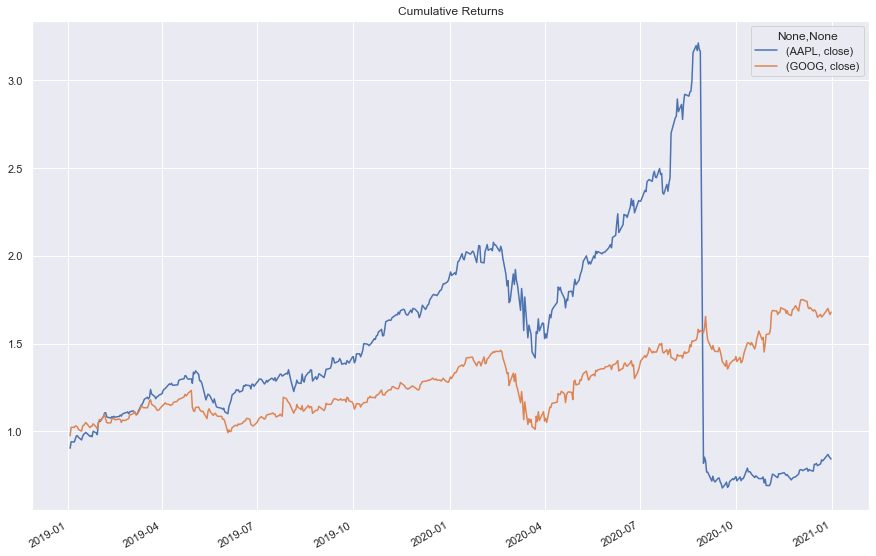

<Figure size 1080x720 with 0 Axes>

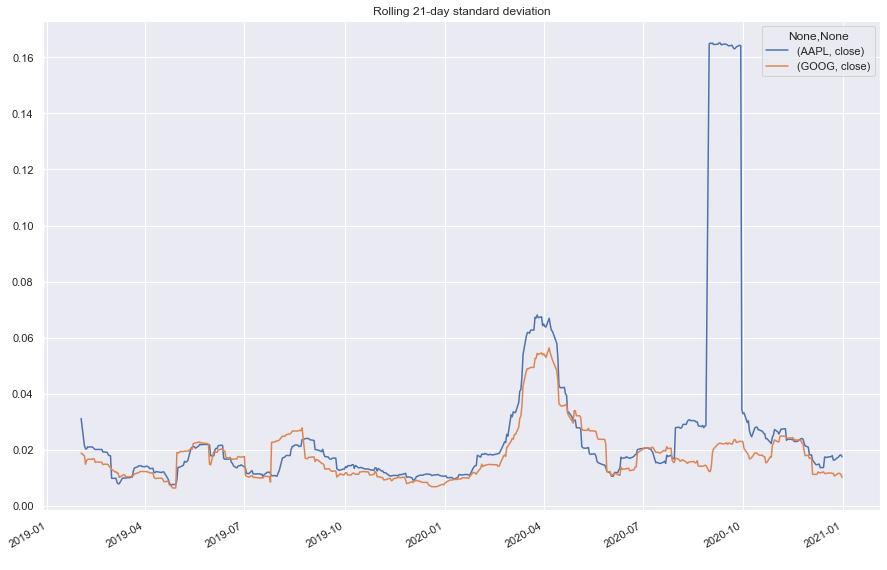

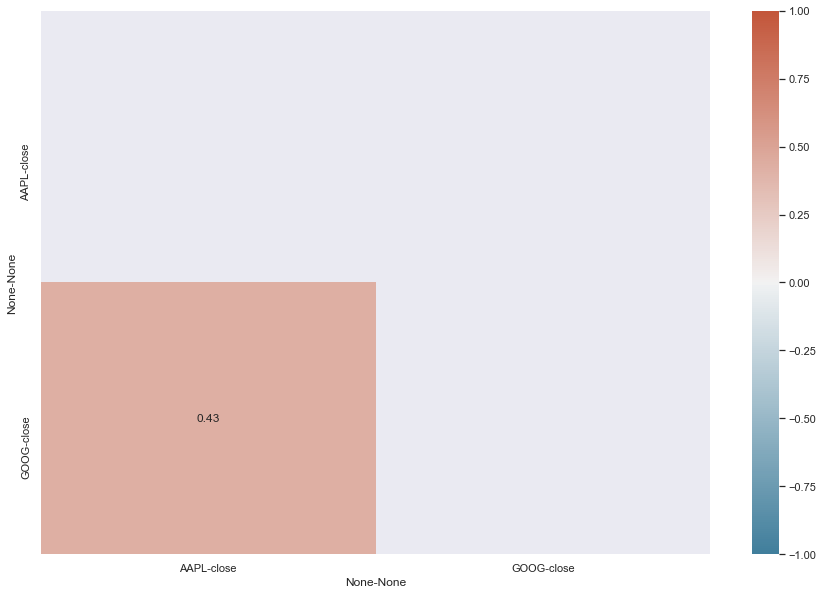

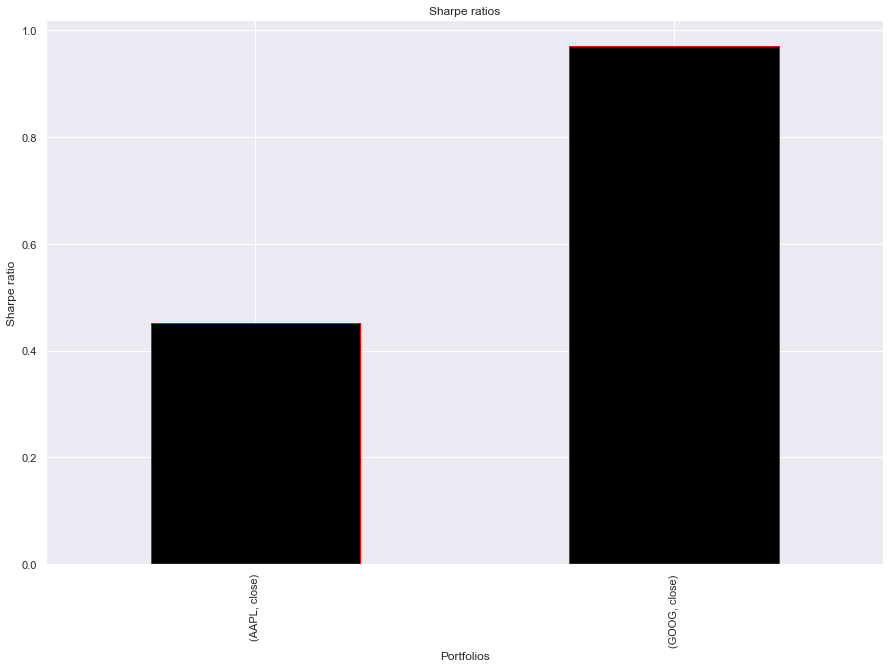

In [ ]:
analyse_my_stock_portfolio2(tickers, timeframe, start_date, end_date, weights, simulate, inv_amt, num_sim, num_trade_days)